# Test weights generated by train.ipynb

Based on https://github.com/RussTedrake/manipulation/blob/master/segmentation_inference.ipynb

In [4]:
# Imports
import fnmatch
import json
import matplotlib.pyplot as plt
import multiprocessing
import numpy as np
import os
from PIL import Image
from IPython.display import display

import torch
import torch.utils.data

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection import MaskRCNN_ResNet50_FPN_Weights
import torchvision.transforms.functional as Tf

In [28]:
dataset_path = 'temp_data'

# ycb = [
#     "003_cracker_box.sdf", "004_sugar_box.sdf", "005_tomato_soup_can.sdf",
#     "006_mustard_bottle.sdf", "009_gelatin_box.sdf", "010_potted_meat_can.sdf"
# ]

pieces = [
    'BB', # : 'Bishop_B.urdf',
    'BW', # : 'Bishop_W.urdf',

    'KB', # : 'King_B.urdf',
    'KW', # : 'King_W.urdf',

    'NB', # : 'Knight_B.urdf',
    'NW', # : 'Knight_W.urdf',

    'PB', # : 'Pawn_B.urdf',
    'PW', # : 'Pawn_W.urdf',

    'QB', # : 'Queen_B.urdf',
    'QW', # : 'Queen_W.urdf',

    'RB', # : 'Rook_B.urdf',
    'RW', # : 'Rook_W.urdf'
]

def get_piece_from_label(label):
    return pieces[label - 1]

num_images = len(fnmatch.filter(os.listdir(dataset_path),'*.png'))
def open_image(idx):
    filename = os.path.join(dataset_path, f"board_{idx:05d}.png")
    return Image.open(filename).convert("RGB")

# model_file = 'weights/L_chess_maskrcnn_model_ep_15.pt'
model_file = 'weights/chess_maskrcnn_model.pt'

In [29]:
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(
        weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

num_classes = len(pieces)+1
model = get_instance_segmentation_model(num_classes)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device(
    'cpu')
model.load_state_dict(
    torch.load(model_file, map_location=device))
model.eval()

model.to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [30]:
# pick one image from the test set (choose between 9950 and 9999)
img = open_image(952)

with torch.no_grad():
    prediction = model([Tf.to_tensor(img).to(device)])

In [31]:
prediction


[{'boxes': tensor([[ 823.2565,  411.6421,  924.7637,  581.8512],
          [ 574.3809,  759.7267,  705.1828,  971.2509],
          [ 813.9756,  511.1920,  923.0026,  693.9453],
          [1498.3896,  412.7782, 1605.7010,  584.5919],
          [ 852.9149,  126.6663,  933.3633,  265.7586],
          [1406.3597,  186.0349, 1492.7996,  331.7676],
          [ 976.8851,  273.9374, 1095.6674,  491.3076],
          [ 343.7484,  687.2944,  497.8818,  974.5765],
          [1353.7679,  439.2611, 1476.8124,  697.9871],
          [1416.8287,  650.1611, 1605.2106,  977.5874]], device='cuda:0'),
  'labels': tensor([ 7,  8,  7,  8,  8,  8,  5,  2,  2, 10], device='cuda:0'),
  'scores': tensor([0.9999, 0.9998, 0.9998, 0.9998, 0.9997, 0.9997, 0.9994, 0.9992, 0.9988,
          0.9983], device='cuda:0'),
  'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
  

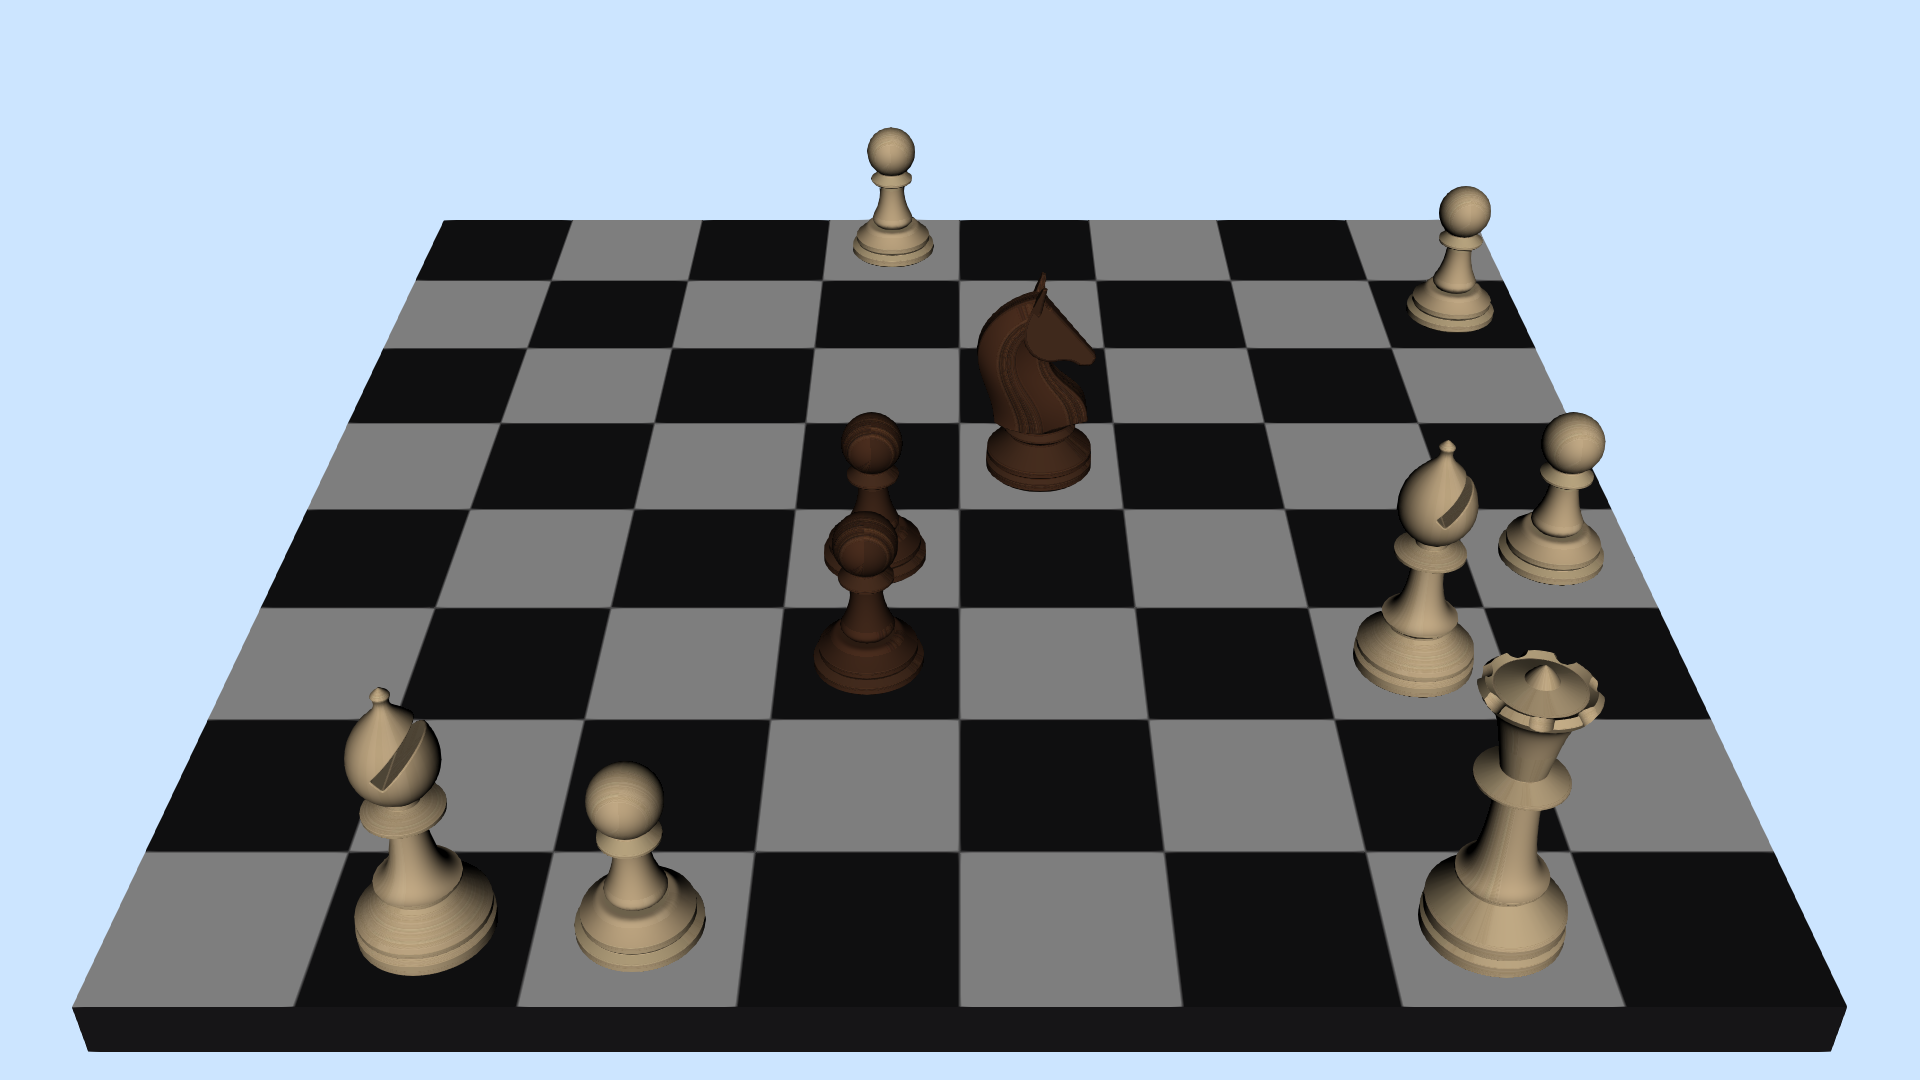

In [32]:
img

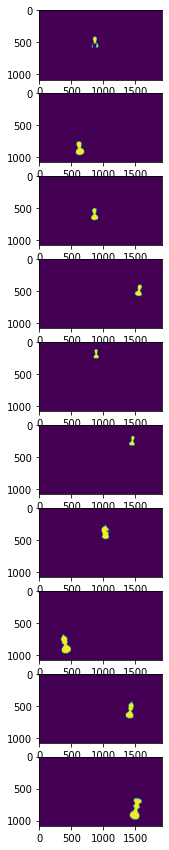

In [33]:
N = prediction[0]['masks'].shape[0]
fig, ax = plt.subplots(N, 1, figsize=(15, 15))
for n in range(prediction[0]['masks'].shape[0]):
    ax[n].imshow(
        np.asarray(
            Image.fromarray(
                prediction[0]['masks'][n, 0].mul(255).byte().cpu().numpy())))

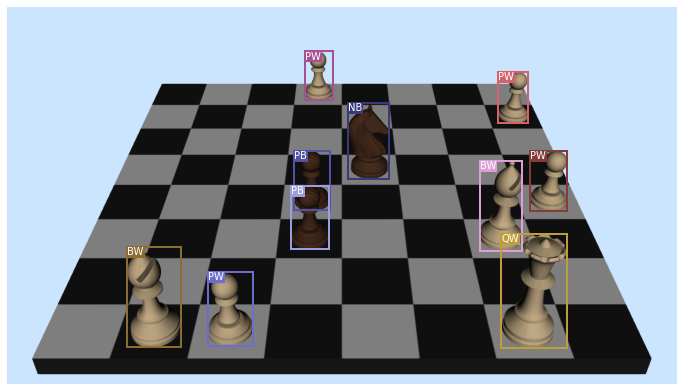

In [34]:
import matplotlib.patches as patches
import random

def plot_prediction():
    img_np = np.array(img)
    fig, ax = plt.subplots(1, figsize=(12,9))
    ax.imshow(img_np)

    cmap = plt.get_cmap('tab20b')
    colors = [cmap(i) for i in np.linspace(0, 1, 20)]

    num_instances = prediction[0]['boxes'].shape[0]
    bbox_colors = random.sample(colors, num_instances)
    boxes = prediction[0]['boxes'].cpu().numpy()
    labels = prediction[0]['labels'].cpu().numpy()

    for i in range(num_instances):
        color = bbox_colors[i]
        bb = boxes[i,:]
        bbox = patches.Rectangle((bb[0], bb[1]), bb[2]-bb[0], bb[3]-bb[1],
                linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(bbox)
        plt.text(bb[0], bb[1], s=get_piece_from_label(labels[i]), 
                color='white', verticalalignment='top',
                bbox={'color': color, 'pad': 0})
    plt.axis('off');

plot_prediction()

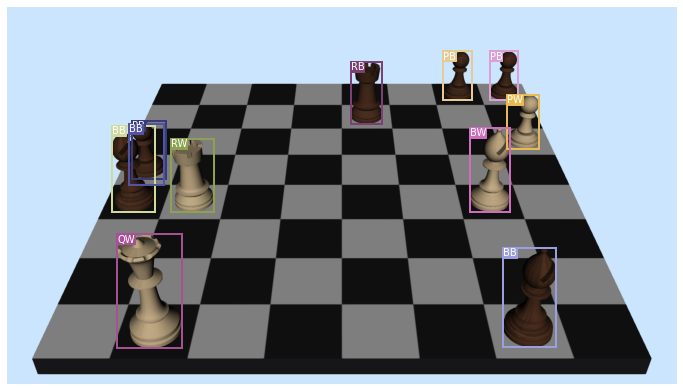

In [35]:
# pick one image from the test set (choose between 9950 and 9999)
img = open_image(95)

with torch.no_grad():
    prediction = model([Tf.to_tensor(img).to(device)])


plot_prediction()

In [36]:
labels = list(prediction[0]['labels'].cpu().detach().numpy())
scores = list(prediction[0]['scores'].cpu().detach().numpy()) 

for i, label in enumerate(labels):
    print(i, label, get_piece_from_label(label), scores[i])

0 7 PB 0.9997584
1 7 PB 0.9997503
2 7 PB 0.99972445
3 8 PW 0.9997193
4 11 RB 0.9992816
5 12 RW 0.9991621
6 1 BB 0.99906796
7 1 BB 0.99896026
8 2 BW 0.99884677
9 10 QW 0.99697757
10 1 BB 0.13525848
